## Anhramonic lattice Dynamics

In this exercise we will learn how to calculate temperature-dependent anharmonic phonons of PbTe
using 2×2×2 ZG supercells and the A-SDM. Unlike Zr, seen in an another Notebook, PbTe is a polar material
and a correction to the dynamical matrix arising from long-range dipole-dipole interactions is essential.
Since the A-SDM relies on the computation of IFCs by finite differences, we employ the mixed space
approach described in J. Phys. Condens. Matter 22 202201 (2010), as implemented in ${\tt matdyn.x}$.
The key flags here to be used are ${\tt fd = .true.}$, $\tt{na\_{ifc} = .true.}$, and ${\tt incl\_epsil = .true.}$.
In this example, the harmonic IFCs matrix is positive definite and therefore the computation of the
polymorphous structure is not required to initialize the A-SDM procedure.

The A-SDM combines the special displacement method with the self-consistent phonon (SCP)
theory; for details of the theory related to this exercise please refer to Refs. [Phys. Rev. B 108, 035155
(2023)] and [D. Hooton, LI. a new treatment of anharmonicity in lattice thermodynamics: I, London
Edinburgh Philos. Mag. J. Sci. 46, 422 (1955)]. The main aim is to find the effective matrix of IFCs
that best describes anharmonicity in the potential energy surface. For this reason we minimize the
trial free energy with respect to the matrix of IFCs which requires, essentially,
to solve self-consistently the following equation:

$\tilde{C}_{p \kappa \alpha, \kappa' \alpha'}(T) = 
\langle \partial U / \partial \tau_{p \kappa \alpha} \partial \tau_{p' \kappa' \alpha'} \rangle_T$

Below we define the main input file which defines all constants and the system we will investigate, in this case PbTe.

In [2]:
import numpy as np
import math
import os 
import shutil
import sys
import subprocess
import EPWpy
from EPWpy import EPWpy
from EPWpy.plotting import plot_bands

# Constants
cm_1_to_meV = 0.124
Ry_to_meV = 13605.66228
# System
nat=2 # number of atoms in the unit cell
ntyp=2 # number of types of atoms
dim1=2 # dimensions of the supercell
dim2=2
dim3=2
nmodesu=nat*3 # total number of phonon modes in the unit cell
dofsuper=dim1*dim2*dim3*nat*3*2 # total number of nuclear degrees of freedom in supercell, factor of 2 for directions
# k-point grid for unit-cell
nk1=6
nk2=6
nk3=6
#
T=300 # target temperature to obtain the anharmonic phonon dispersion
# Number of CPUs and pools
ncores=56*4
npoolsuper = round((nk1*nk2*nk3) / (dim1*dim2*dim3) / 2)
print("k-point parallelization (npools):", npoolsuper)
ncoresuper = ncores - ncores % npoolsuper # take modulo
print("Number of cores to be used:", ncoresuper)
#
font=16
#
#Define folder locations, prefix and number of cores
folder='./'
cores='224'
#pseudo = os.getcwd() + '/pseudos'
pseudo='/home1/07369/mzach/epwpypseudos'
QE = '/home1/07369/mzach/codes/q-e_dev_2024/bin'
######Define the directory of installation##############
#
prefix='PbTe'
flfrc='\''+str(prefix)+'.fc\''
#
##########################################################################
# Download pseudo from Pseudo-Dojo library
print("===========================================")
print("Downloading pseudo from Pseudo-Dojo library")
#
#define elements 
elements = ['Pb', 'Te']
masses = [207.2, 127.6]
#  Download pseudos for all elements, one could also use pseudo_auto option below
for i in range(0, ntyp):
    if os.path.exists(f'./{elements[i]}.upf'): # If upf file exists then 
        os.remove(f'./{elements[i]}.upf')      # remove it from parent directory
    !wget http://www.pseudo-dojo.org/pseudos/nc-sr-04_pbesol_standard/{str(elements[i])}.upf.gz
#    !wget http://www.pseudo-dojo.org/pseudos/nc-fr-04_pbesol_standard/{str(elements[i])}.upf.gz # for SOC calculations
    !gunzip {str(elements[i])}.upf.gz 
    if os.path.exists(f'/{pseudo}/{elements[i]}.upf'): # If upf file exists in pseudo directory
        os.remove(f'/{pseudo}/{elements[i]}.upf')      # then remove it
    #
    shutil.move(f'./{elements[i]}.upf', pseudo) # mv upf file in pseudo directory 
#########################################################################
#
# Define the system used for the calculations
pbte=EPWpy.EPWpy({'prefix':f'\'{prefix}\'','restart_mode':'\'from_scratch\'','calculation':'\'scf\'',
                  'verbosity':'\'high\'',
                  'celldm(1)':'12.17740', 
                  #'pseudo_auto':True,
                  'pseudo_dir':'\''+str(pseudo)+'\'',
                  'ibrav':2,
                  'nat':nat,
                  'ntyp':ntyp,
                  'ecutwfc':'50', 'ecutrho':'200',
                  'atomic_species':[f'{elements[0]}',f'{elements[1]}'],
                  'mass':[masses[0], masses[1]],
                  'atoms':[f'{elements[0]}',f'{elements[1]}'],
                  'pseudo':[f'{elements[0]}.upf',f'{elements[1]}.upf'],                  
                  'atomic_position_type':'{angstroms}',
                  'atomic_pos':np.array([[-3.222, 3.222, 3.222],[0.0, 0.0, 0.0]]),
                 },code=QE,env='ibrun',system = prefix)
pbte.serial = True

#######Printing any attribute######
pseudopot=pbte.__dict__['pw_atomic_species']['pseudo'][0]
print('pseudopotential:', pbte.__dict__['pw_atomic_species']['pseudo'][:])
print('pseudopotential directory:', pbte.__dict__['pw_control']['pseudo_dir'])
print('prefix:',prefix)

os.system('module list')

k-point parallelization (npools): 14
Number of cores to be used: 224
--2024-07-05 08:02:44--  http://www.pseudo-dojo.org/pseudos/nc-sr-04_pbesol_standard/Pb.upf.gz
Resolving www.pseudo-dojo.org (www.pseudo-dojo.org)... 130.104.22.53
Connecting to www.pseudo-dojo.org (www.pseudo-dojo.org)|130.104.22.53|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82213 (80K) [application/x-gzip]
Saving to: ‘Pb.upf.gz’

100%[======================================>] 82,213       319KB/s   in 0.3s   

2024-07-05 08:02:44 (319 KB/s) - ‘Pb.upf.gz’ saved [82213/82213]

--2024-07-05 08:02:45--  http://www.pseudo-dojo.org/pseudos/nc-sr-04_pbesol_standard/Te.upf.gz
Resolving www.pseudo-dojo.org (www.pseudo-dojo.org)... 130.104.22.53
Connecting to www.pseudo-dojo.org (www.pseudo-dojo.org)|130.104.22.53|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65660 (64K) [application/x-gzip]
Saving to: ‘Te.upf.gz’

100%[======================================>] 65,660    

0

### Self Consistent Field (SCF) Calculations

We first solve the Kohn-Sham equations to obtain the Kohn-Sham orbitals $\phi_v(r)$, $r$ is the electronic position (generally a mesh grid), $R$ is the position of ions.

$E[\phi_v,R]=-\frac{\hbar^2}{2m}\sum_v{\int{\phi_v^\star(r)\nabla^2\phi_v(r)dr}+\int{V_R(r)n(r)dr}+\frac{e^2}{2}\int{\frac{n(r)n(r')}{|r-r'|}drdr'}+E_{xc}[n(r')]+\sum_{I\neq J}{\frac{e^2}{2}\frac{Z_IZ_J}{|R_I-R_J|}}}$

We minimize $E(R)=min(E[\phi_v,R])$

Where, $\Big(-\frac{\hbar^2}{2m}\nabla^2+V_{KS}(r)\Big)\phi_v(r)=\epsilon_v\phi_v(r)$

In [3]:
## Create SCF input file ##
pbte.scf(electrons={'conv_thr':'1E-7',
                       'mixing_beta':'0.7'},
            kpoints={'kpoints':[[nk1,nk2,nk3]],
                     'kpoints_type':'automatic'},
            name='scf')
## Prepare folders and copy necessary files ##
pbte.prepare(1,type_run='scf')
## Run calculation ##
pbte.run(48)

-- -- -- -- -- -- -- -- -- -- --  Calculation: scf  -- -- -- -- -- -- -- -- -- -- -- 
Running scf |████████████████████████████████████████| in 0.0s (196.05/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [4]:
pbte.file = './'+str(prefix)+'/scf/scf.out'
pbte.get_QE_status()

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Error in calculation ./PbTe/scf/scf.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


### Phonon Calculations

Here we evaluate the harmonic phonon energies and displacement vectors in the unit cell using the density-functional perturbation theory (DFPT)

https://docs.epw-code.org/_downloads/b3f5899664a87fcdd6dcacc262e6f103/Mon.1.Giannozzi.pdf

In this example we evaluate phonons in a $3\times3\times3$ $q$-grid.

In [5]:
## Create PH input file ##
pbte.ph(phonons={'nq1':2,
                 'nq2':2,
                 'nq3':2,
                 'fildvscf':'\' \''})
## Prepare folders and copy necessary files ##
pbte.prepare(1,type_run='ph')
## Run calculation ##
pbte.run(48,type_run='ph')

-- -- -- -- -- -- -- -- -- -- --  Calculation: ph  -- -- -- -- -- -- -- -- -- -- -- 
Running ph |████████████████████████████████████████| in 0.0s (191.26/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [6]:
pbte.file = './'+str(prefix)+'/ph/ph.out'
pbte.get_QE_status()

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Error in calculation ./PbTe/ph/ph.out
TACC:  Starting up job 6434316 

TACC:  Starting parallel tasks... 


-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


### Interatomic Force Constants (IFCs)

In order to produce the ZG configurations we first need to evaluate the interatomic forces constants, as they will provide information on how to displace the atoms. These constants correspond to second derivatives of the total potential energy, that is: $C_{\kappa\alpha\rho\kappa'\alpha'\rho'}=\partial^{2}U/\partial\tau_{\kappa\alpha\rho}\tau_{\kappa'\alpha'\rho'}$, but do not curry any temperature dependence. 

In [7]:
## Create q2r input file ##
pbte.q2r(q2r={'fildyn':'\''+str(prefix)+'.dyn\'',
                   'flfrc':flfrc,
                   'zasr':'\'crystal\''})
## Prepare folders and copy necessary files ##
pbte.prepare(1,type_run='q2r')
## Run calculation ##
pbte.run(1,type_run='q2r')

-- -- -- -- -- -- -- -- -- -- --  Calculation: q2r  -- -- -- -- -- -- -- -- -- -- -- 
Running q2r |████████████████████████████████████████| in 0.0s (200.99/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


### Plot the harmonic phonon dispersion

Here we perform a ${\tt matdyn.x}$ calculation to obtain the harmonic phonon frequencies.

In [8]:
pbte.matdyn(name='matdyn',
          matdyn={'flfrq':'\''+str(prefix)+'_harm.freq\'',
                  'flfrc':flfrc},
          kpoints={'kpoints':[['0.0', '0.5', '0.5', '100'], #X
                              ['0.0', '0.0', '0.0', '100'], #Gamma 
                              ['0.0', '0.5', '0.5', '1']]}) # X
                          

pbte.prepare(1,type_run='matdyn')

pbte.run(1,type_run='matdyn')

-- -- -- -- -- -- -- -- -- -- --  Calculation: matdyn  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running phonon bands calculation
Running matdyn |████████████████████████████████████████| in 0.0s (113.82/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


No handles with labels found to put in legend.


Current Directory: /work2/07369/mzach/frontera/QE/Notebooks


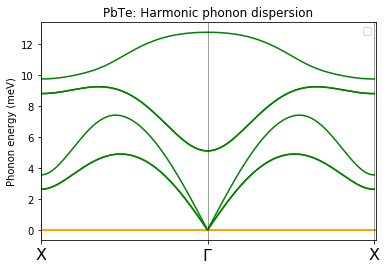

In [10]:
# Plot the phonon dispersion
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# remember to "module load python3.7" from terminal
import matplotlib.pyplot as plt

data = np.loadtxt(str(os.getcwd())+'/'+str(prefix)+'/ph/'+str(prefix)+'_harm.freq.gp')                               

plt.plot([0,2.01], [0, 0], color='orange', linewidth=2)
plt.xlim(0, 2.01)
for i in range(1, nmodesu + 1):
    plt.plot(data[:, 0], data[:, i]*cm_1_to_meV,color='green')
    
plt.title(f'{prefix}: Harmonic phonon dispersion')

plt.legend()

plt.ylabel(r'Phonon energy (meV)')

from matplotlib import font_manager
#
ticks= [0.0, 1.0, 2.0]
labels=['X', '$\Gamma$', 'X']

for ii in ticks:
    plt.axvline(ii, linewidth=0.75, color='k', alpha=0.5)

# text labels
font_prop = font_manager.FontProperties(size=16)
plt.xticks(ticks, labels, fontproperties=font_prop, size =16)

plt.show()


### ZG displacements to obtain the polymorphous structure

To create the ${\tt zg.in}$ file see below. 

The input format of ${{\tt  inputzg}}$ list is the same as in a standard ${\tt ZG.x}$ calculation. We remark
that here we are using a 2×2×2 supercell and therefore ${\tt incl\_qA = .true.}$.  The flag
${\tt ASDM}$ is set to true to enable the A-SDM procedure; it allows the code to read the input variables in the
list ${{\tt  inputazg}}$. The cell paramaters, number of atoms, k-grid, and atomic coordinates are modified automatically based on the supercell dimensions. The code will always generate the lattice information in angstroms.

In [17]:
## Create ZG input file ##
#
pbte.zg(inputzg={'flfrc':flfrc,
               'T':T,
               'dim1':dim1,
               'dim2':dim2,
               'dim3':dim3,
               'atm_zg(1)':f'\'{elements[0]}\'',
               'atm_zg(2)':f'\'{elements[1]}\'',
               'error_thresh':'0.4',
               'niters':'4000', 'incl_qA':'.true.',
               'ASDM':'.true.'},
             inputazg={'poly':'.false.',
                       'poly_fd_forces':'.false.',
                       'iter_idx':1, 
                       'apply_fd':'.true.'}
            )

## Prepare folders and copy necessary files ##
pbte.prepare(1,type_run='zg')
## Run calculation ##
pbte.run(2,type_run='zg')

-- -- -- -- -- -- -- -- -- -- --  Calculation: zg  -- -- -- -- -- -- -- -- -- -- -- 
Running zg |████████████████████████████████████████| in 0.0s (192.62/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [18]:
pbte.file = './'+str(prefix)+'/zg/zg.out'
pbte.get_QE_status()

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/zg.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


Run scf calculations for files ${\tt ZG-scf\_300.00K\_iter\_01\_XXXX.in}$ and save all scf outputs in the folder
${\bf fd\_forces}$. The cell below is as before but with a new name for ${\tt filein,\,fileout}$ variables.

In [19]:
# Calculate forces for iteration 1
os.chdir('./'+str(prefix)+'/zg/') # go to zg directory where all ZG-scf*in files are located
current_directory = os.getcwd()
print("Current Directory:", current_directory)
#
print("Number of cores:", ncoresuper)
print("Number of pools:", npoolsuper)
#
if not os.path.isdir('fd_forces'):
    os.mkdir('fd_forces')
#
from EPWpy.EPWpy_run import py_run
# iteration index
itr_idx = 1
# Loop over the range from 0001 to 1000
for i in range(1,dofsuper+1):
    pbte.env = f'ibrun -np {ncoresuper}'
    pbte.code = '/home1/07369/mzach/codes/q-e_dev_2024/bin'
    pbte.run_QE=py_run(1,pbte.env,pbte.code)
    if not os.path.isdir(f'{i:04d}'):
        os.mkdir(f'{i:04d}') # create directory 0001, 0002 ...
    pbte.run_QE.dir = f'./{i:04d}' # Calculations are performed in separate folders 0001, 0002 ...
    pbte.run_QE.filein=f'ZG-scf_{T}.00K_iter_{itr_idx:02d}_{i:04d}.in'
    pbte.run_QE.fileout=f'ZG-scf_{T}.00K_iter_{itr_idx:02d}_{i:04d}.out'
    pbte.run_QE.util=f'ibrun -np {ncoresuper} pw.x -nk {npoolsuper} < ../ZG-scf_{T}.00K_iter_{itr_idx:02d}_{i:04d}.in > ZG-scf_{T}.00K_iter_{itr_idx:02d}_{i:04d}.out'
    pbte.run_QE.serial=True
    pbte.run_QE.runner()
    shutil.copy(f'ZG-scf_{T}.00K_iter_{itr_idx:02d}_{i:04d}.out','../fd_forces/.')
    os.chdir('../')

os.chdir('../../') # return to parent directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: /work2/07369/mzach/frontera/QE/Notebooks/PbTe/zg
Number of cores: 224
Number of pools: 14
Current Directory: /work2/07369/mzach/frontera/QE/Notebooks


In [20]:
# iteration index
itr_idx = 1
# check if calculations were succesful
for i in range(1,dofsuper+1):
    pbte.file = './'+str(prefix)+f'/zg/fd_forces/ZG-scf_{T}.00K_iter_{itr_idx:02d}_{i:04d}.out'
    pbte.get_QE_status()

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_01_0001.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_01_0002.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_01_0003.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_01_0004.out

-- -- -- -- -- -- -

Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_01_0044.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_01_0045.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_01_0046.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_01_0047.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -

Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_01_0093.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_01_0094.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_01_0095.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_01_0096.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


### Self Consistent Phonon Theory:Obtain the IFC file for iteration 1

If all calculations run successfully, the code evaluates the IFCs using the finite differences formula and
prints the following new files related to the first iteration:

(i) ${\tt FORCE\_CONSTANTS\_300.00K\_iter\_01}$,

(ii) ${\tt FORCE\_CONSTANTS\_sym\_300.00K\_iter\_01}$,

and (iii) ${\tt 300.00K\_iter\_01.fc}$ which contains the symmetrized IFCs in the same $\verb|q2r.x|$ output format to be used for the next A-SDM iteration.


In [25]:
## Create zg input file to generate the temperature-dependent IFCs at iteration 1
#
pbte.zg(inputzg={'flfrc':flfrc,
               'T':T,
               'dim1':dim1,
               'dim2':dim2,
               'dim3':dim3,
               'atm_zg(1)':f'\'{elements[0]}\'',
               'atm_zg(2)':f'\'{elements[1]}\'',
               'error_thresh':'0.4',
               'niters':'4000',
               'ASDM':'.true.'},
              inputazg={'poly':'.false.','poly_fd_forces':'.false.',
                        'iter_idx':1,
                        'apply_fd':'.false.', 
                        'read_fd_forces':'.true.','mixing':'.false.',
                        'incl_epsil':'.true.'}
            )
## Prepare folders and copy necessary files ##
pbte.prepare(1,type_run='zg')
## Run calculation ##
pbte.run(2,type_run='zg')

-- -- -- -- -- -- -- -- -- -- --  Calculation: zg  -- -- -- -- -- -- -- -- -- -- -- 
Running zg |████████████████████████████████████████| in 0.0s (159.49/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [22]:
pbte.file = './'+str(prefix)+'/zg/zg.out'
pbte.get_QE_status()

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Error in calculation ./PbTe/zg/zg.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


### Plot the anharmonic phonons from iteration 1

Note here that we add the flags ${\tt fd = .true.}$, ${\tt na\_ifc = .true.}$ to account
for long range effects since the IFCs in ${\tt 300.00K\_iter\_01.fc}$ are obtained by finite differences.

In [26]:
# perform a matdyn.x calculation using ifc file 'T_iter_01.fc'
pbte.matdyn(name='matdyn',
          matdyn={'flfrq':'\'./'+str(prefix)+'_01.freq\'',
                  'flfrc':f'\'../zg/{T}.00K_iter_01.fc\'',
                  'fd':'.true.',  
                  'na_ifc':'.true.'}, 
          kpoints={'kpoints':[['0.0', '0.5', '0.5', '100'], #X
                              ['0.0', '0.0', '0.0', '100'], #Gamma 
                              ['0.0', '0.5', '0.5', '1']]}) # X
                          

pbte.prepare(1,type_run='matdyn')

pbte.run(1,type_run='matdyn')

-- -- -- -- -- -- -- -- -- -- --  Calculation: matdyn  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running phonon bands calculation
Running matdyn |████████████████████████████████████████| in 0.0s (153.04/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


Current Directory: /work2/07369/mzach/frontera/QE/Notebooks


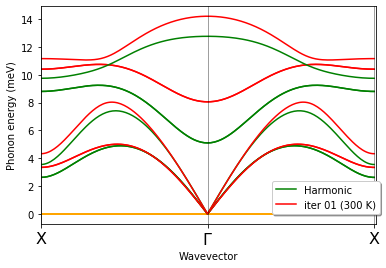

In [27]:
# Plot the phonon dispersion
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# remember to "module load python3.7" from terminal
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

data = np.loadtxt(str(os.getcwd())+'/'+f'./'+str(prefix)+'/ph/'+str(prefix)+'_harm.freq.gp')                               
data2 = np.loadtxt(str(os.getcwd())+'/'+f'./'+str(prefix)+'/ph/'+str(prefix)+'_01.freq.gp')

plt.plot([0, 2.01], [0, 0], color='orange', linewidth=2)
plt.xlim(0,  2.01)
for i in range(1, nmodesu + 1):
    plt.plot(data[:, 0], data[:, i]*cm_1_to_meV,color='green')
    plt.plot(data2[:, 0], data2[:, i]*cm_1_to_meV,color='red')

ax.plot([], [], color='green', label='Harmonic') 
ax.plot([], [], color='red', label='iter 01 (300 K)')
ax.legend(loc='upper center', bbox_to_anchor=(0.85, 0.22), shadow=True, ncol=1)

plt.xlabel('Wavevector')
plt.ylabel('Phonon energy (meV)')


from matplotlib import font_manager
#
ticks= [0.0, 1.0, 2.0]
labels=['X', '$\Gamma$', 'X']

for ii in ticks:
    plt.axvline(ii, linewidth=0.75, color='k', alpha=0.5)

# text labels
font_prop = font_manager.FontProperties(size=16)
plt.xticks(ticks, labels, fontproperties=font_prop, size =16)

#plt.legend()
plt.show()

Here, we compare the phonon dispersion of PbTe at $T =300$ K obtained at the first iteration (red)
with the harmonic phonon dispersion (green). 
It is evident that anharmonicity is important to describe lattice dynamics in PbTe at elevated tem-
peratures, particularly for the optical modes. T In the following we proceed to the second iteration and
re-evaluate the phonon dispersion of PbTe at $T = 300$ K starting from the IFCs of the previous iteration. We repeat until we obtain convergence. 


### Now repeat the procedure until convergence

In [28]:
## Create zg input file to start iteration 2 ##
#
pbte.zg(inputzg={'flfrc':f'\'{T}.00K_iter_01.fc\'',
               'T':T,
               'dim1':dim1,
               'dim2':dim2,
               'dim3':dim3,
               'error_thresh':'0.4',
               'niters':'4000',
               'fd':'.true.',  
               'na_ifc':'.true.',
               'ASDM':'.true.'},
              inputazg={'poly':'.false.','poly_fd_forces':'.false.',
                        'iter_idx':2,
                        'apply_fd':'.true.', 
                        'read_fd_forces':'.false.','mixing':'.false.'}
            )
# Note here that we add the flags 𝚏𝚍 =.𝚝𝚛𝚞𝚎., 𝚗𝚊_𝚒𝚏𝚌 =.𝚝𝚛𝚞𝚎. to account for long range 
# effects since the IFCs in 𝟹𝟶𝟶.𝟶𝟶𝙺_𝚒𝚝𝚎𝚛_𝟶𝟷.𝚏𝚌 are obtained by finite differences.
## Prepare folders and copy necessary files ##
pbte.prepare(1,type_run='zg')
## Run calculation ##
pbte.run(2,type_run='zg')

-- -- -- -- -- -- -- -- -- -- --  Calculation: zg  -- -- -- -- -- -- -- -- -- -- -- 
Running zg |████████████████████████████████████████| in 0.0s (193.13/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [29]:
pbte.file = './'+str(prefix)+'/zg/zg.out'
pbte.get_QE_status()

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/zg.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [30]:
# Calculate forces for iteration 2
os.chdir('./'+str(prefix)+'/zg/') # go to zg directory where all ZG-scf*in files are located
current_directory = os.getcwd()
print("Current Directory:", current_directory)
#
print("Number of cores:", ncoresuper)
print("Number of pools:", npoolsuper)
#
from EPWpy.EPWpy_run import py_run
# iteration index
itr_idx = 2
# Loop over the range from 0001 to dofsuper
for i in range(1,dofsuper+1):
    pbte.env = f'ibrun -np {ncoresuper}'
    pbte.code = '/home1/07369/mzach/codes/q-e_dev_2024/bin'
    pbte.run_QE=py_run(1,pbte.env,pbte.code) 
    pbte.run_QE.dir = f'./{i:04d}' # Calculations are performed in separate folders 0001, 0002 ...
    pbte.run_QE.filein=f'ZG-scf_{T}.00K_iter_{itr_idx:02d}_{i:04d}.in'
    pbte.run_QE.fileout=f'ZG-scf_{T}.00K_iter_{itr_idx:02d}_{i:04d}.out'
    pbte.run_QE.util=f'ibrun -np {ncoresuper} pw.x -nk {npoolsuper} < ../ZG-scf_{T}.00K_iter_{itr_idx:02d}_{i:04d}.in > ZG-scf_{T}.00K_iter_{itr_idx:02d}_{i:04d}.out'
    pbte.run_QE.serial=True
    pbte.run_QE.runner()
    shutil.copy(f'ZG-scf_{T}.00K_iter_{itr_idx:02d}_{i:04d}.out','../fd_forces/.')
    os.chdir('../')

os.chdir('../../')
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: /work2/07369/mzach/frontera/QE/Notebooks/PbTe/zg
Number of cores: 224
Number of pools: 14
Current Directory: /work2/07369/mzach/frontera/QE/Notebooks


In [31]:
# iteration index
itr_idx = 2
# check if calculations were succesful
for i in range(1,dofsuper+1):
    pbte.file = './'+str(prefix)+f'/zg/fd_forces/ZG-scf_{T}.00K_iter_{itr_idx:02d}_{i:04d}.out'
    pbte.get_QE_status()

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_02_0001.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_02_0002.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_02_0003.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_02_0004.out

-- -- -- -- -- -- -

Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_02_0040.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_02_0041.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_02_0042.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_02_0043.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -

Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_02_0081.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_02_0082.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_02_0083.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in ./PbTe/zg/fd_forces/ZG-scf_300.00K_iter_02_0084.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -

In [32]:
# Create the zg input file to generate the temperature-dependent IFCs at iteration 2 (mixing is applied)
#
pbte.zg(inputzg={'flfrc':f'\'{T}.00K_iter_01.fc\'',
               'T':T,
               'dim1':dim1,
               'dim2':dim2,
               'dim3':dim3,
               'error_thresh':'0.4',
               'niters':'4000',
               'fd':'.true.',  
               'na_ifc':'.true.',
               'ASDM':'.true.'},
              inputazg={'poly':'.false.','poly_fd_forces':'.false.',
                        'iter_idx0':1, 'iter_idx':2,
                        'apply_fd':'.false.',
                        'incl_epsil':'.true.',
                        'read_fd_forces':'.true.','mixing':'.true.'}
            )
# NOTE: Mixing is performed between the current and all previous IFCs matrices as 
# specified by the input variables iter_idx0 and iter_idx. We found that for the current system
# convergence is achieved faster. Instead, one can perform mixing between consecutive iterations 
# (current and previous iteration) by choosing appropriately iter_idx0 and iter_idx. In any case the
# converged result should be similar.
#
## Prepare folders and copy necessary files ##
pbte.prepare(1,type_run='zg')
## Run calculation ##
pbte.run(2,type_run='zg')

-- -- -- -- -- -- -- -- -- -- --  Calculation: zg  -- -- -- -- -- -- -- -- -- -- -- 
Running zg |████████████████████████████████████████| in 0.0s (164.51/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [33]:
pbte.file = './'+str(prefix)+'/zg/zg.out'
pbte.get_QE_status()

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Error in calculation ./PbTe/zg/zg.out
TACC:  Starting up job 6434316 

TACC:  Starting parallel tasks... 


-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [34]:
# perform a matdyn.x calculation using ifc file 'T_iter_02.fc'
pbte.matdyn(name='matdyn',
          matdyn={'flfrq':'\'./'+str(prefix)+'_02.freq\'',
                  'flfrc':f'\'../zg/{T}.00K_iter_02.fc\'',
                  'fd':'.true.',  
                  'na_ifc':'.true.'}, 
          kpoints={'kpoints':[['0.0', '0.5', '0.5', '100'], #X
                              ['0.0', '0.0', '0.0', '100'], #Gamma 
                              ['0.0', '0.5', '0.5', '1']]}) # X
                          

pbte.prepare(1,type_run='matdyn')

pbte.run(1,type_run='matdyn')

-- -- -- -- -- -- -- -- -- -- --  Calculation: matdyn  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running phonon bands calculation
Running matdyn |████████████████████████████████████████| in 0.0s (151.11/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


Current Directory: /work2/07369/mzach/frontera/QE/Notebooks


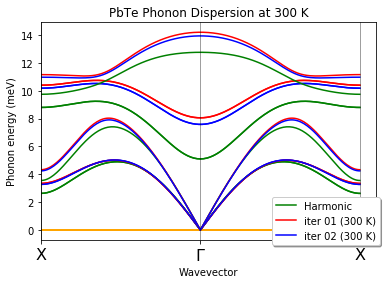

In [35]:
# Plot the phonon dispersion
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# remember to "module load python3.7" from terminal
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

data = np.loadtxt(str(os.getcwd())+'/'+f'./'+str(prefix)+'/ph/'+str(prefix)+'_harm.freq.gp')                               
data2 = np.loadtxt(str(os.getcwd())+'/'+f'./'+str(prefix)+'/ph/'+str(prefix)+'_01.freq.gp')
data3 = np.loadtxt(str(os.getcwd())+'/'+f'./'+str(prefix)+'/ph/'+str(prefix)+'_02.freq.gp')

plt.plot([0, 2.1], [0, 0], color='orange', linewidth=2)
plt.xlim(0, 2.1)
for i in range(1, nmodesu + 1):
    plt.plot(data[:, 0], data[:, i]*cm_1_to_meV,color='green')
    plt.plot(data2[:, 0], data2[:, i]*cm_1_to_meV,color='red')
    plt.plot(data3[:, 0], data3[:, i]*cm_1_to_meV,color='blue')
    
ax.plot([], [], color='green', label='Harmonic') 
ax.plot([], [], color='red', label='iter 01 (300 K)')
ax.plot([], [], color='blue', label='iter 02 (300 K)')
ax.legend(loc='upper center', bbox_to_anchor=(0.85, 0.22), shadow=True, ncol=1)

plt.title('PbTe Phonon Dispersion at 300 K')
plt.xlabel('Wavevector')
plt.ylabel('Phonon energy (meV)')
#
from matplotlib import font_manager
#
ticks= [0.0, 1.0, 2.0]
labels=['X', '$\Gamma$', 'X']

for ii in ticks:
    plt.axvline(ii, linewidth=0.75, color='k', alpha=0.5)

# text labels
font_prop = font_manager.FontProperties(size=16)
plt.xticks(ticks, labels, fontproperties=font_prop, size =16)

#plt.legend()
plt.show()

Here, we compare the phonon dispersion of PbTe at $T =300$ K obtained at the second iteration (blue)
with the one at first iteration (red), and the harmonic phonon dispersion (green). 
As we can see the result at the second iteration is almost converged. One can repeat further iterative steps to check convergence. 

### Homework

As a homework repeat the previous steps for the third and fourth iterations. 

As a homework, also calculate the phonons of PbTe at $T = 500$ K and $T = 700$ K. 
HINT: Simply change the global variable for the target temperature ($T$) and repeat the ZG calculations.
**This is the great advantage of using Jupyter Notebooks, where the repetition of commands and redesigning submission scripts are no longer time-consuming**.

$\underline{\large{\rm To\,this\,end\,we\,also\,discuss\,two\,final\,important\,points}}$

**(a)** A quicker and more accurate way than checking the phonon dispersion is to plot the Frobenius norm ($||.||$) of the leading component of the IFCs matrix as suggested in Ref. [Phys. Rev. B 84, 180301(R) (2011)]. This information can be found by analysis of the first 3 × 3 matrix in ${\tt FORCE\_CONSTANTS\_sym\_1188.00K\_iter\_XX}$, where ${\tt XX}$ indicates the iteration. We note that convergence in the IFCs guarantees essentially minimization of the system’s free energy. 

**(b)**   A full self-consistent phonon theory also minimizes the trial free energy with respect to nuclear coordinates. As seen in the lectures, one can employ the Newton-Raphson method and find the nuclear coordinates for which $\langle \partial U / \partial \tau_{\kappa \alpha}\rangle_T = 0$. This requires to solve self-consistently
the equation

$
\tau^{\rm new}_{p \kappa \alpha} (T) = \tau_{p \kappa \alpha} (T) + \tilde{C}^{-1}_{p \kappa \alpha, p \kappa \alpha} (T)   \langle F_{p \kappa \alpha}\rangle_T
$

using at each iterative step $\tilde{C}_{p \kappa \alpha, p \kappa \alpha} (T)$. In order to
account for this feature in the A-SDM we need to set the flag ${\tt{update\_equil = .true.}}$ when
$\tt{ read\_fd\_forces = .true.}$. If we use this flag for the case of cubic PbTe,
then the code will give $\tau^{\rm new}_{p \kappa \alpha} (T) = \tau_{p \kappa \alpha} (T)$
(i.e. no change of the nuclear coordinates) at every iterative step. This comes as no surprise
since symmetries are enforced and atoms in PbTe occupy only special Wyckoff positions. However, for
systems containing atoms at general Wyckoff positions, the equation above will give new thermal
equilibrium positions at each temperature that contribute to the minimization of the free energy. See for
example the case of hydride compounds explored in Ref. [Commun. Phys. 6, 298 (2023)]. 